In [1]:
import psycopg2

import os
from dotenv import load_dotenv

load_dotenv()

database = "test"
password = os.getenv("DB_PASSWORD")
user = os.getenv("DB_USER")

### Задание 1
Выполнить задачи из предыдущего урока, но с использованием python (кроме 4 - 6)
1. Создать бд на основе данных с сайта о вылетах самолетов (10 записей)  
2. Вывести все самолеты принадлежащие компании АЭРОФЛОТ  
3. Вывести все самолеты не принадлежащие компании АЭРОФЛОТ  
7. Изменить данные для всех самолетов принадлежащие компании АЭРОФЛОТ на АЭРОфЛОТ2  
8. Удалить все данные о компании S7  

*чтобы чуть сократить код всё заверну в класс (я понимаю, что можно открыть один раз подключение, но хотел чтобы задания можно было запускать независимо)*

In [2]:
class ConnectDB():
    def __init__(self, database, user, password, host = "127.0.0.1", port = "5432"):
        self.__database = database
        self.__user = user
        self.__password = password
        self.__host = host
        self.__port = port

    def __enter__(self):
        self.__conn = psycopg2.connect(
            database = self.__database,
            user = self.__user,
            password = self.__password,
            host = self.__host,
            port = self.__port,
        )
        self.__conn.autocommit = True
        self.__cursor = self.__conn.cursor()
        return self
    
    def __exit__(self, type, value, traceback):
        self.__cursor.close()
        self.__conn.close()

    def execute(self, query, vars = None):
        self.__cursor.execute(query, vars)
    
    def select(self, query, vars = None):
        self.__cursor.execute(query, vars)
        return self.__cursor.fetchall()
    
    def copy_to(self, file, table, sep = ','):
        self.__cursor.copy_to(file = file, table = table, sep = sep)

In [3]:
flights = [
    ("Победа", "16:00"),
    ("Аэрофлот", "17:00"),
    ("Аэрофлот", "18:00"),
    ("S7", "15:30"),
    ("S7", "11:20"),
    ("S7", "18:25"),
    ("Победа", "21:37"),
    ("Победа", "6:36"),
    ("Аэрофлот", "2:13"),
    ("Аэрофлот", "9:41"),
]

with ConnectDB(database = database, user = user, password = password) as connect:
    connect.execute("truncate table flights") # Для очистки таблицы
    # Пункт 1
    for fl in flights:
        connect.execute("insert into flights values (%s, %s)", fl)
    print(connect.select("select * from flights")) # Проверим что записи добавились в БД

    # Пункт 2
    print(connect.select("select * from flights where name = 'Аэрофлот'"))

    # Пункт 3
    print(connect.select("select * from flights where name != 'Аэрофлот'"))

    # Пункт 7
    connect.execute("update flights set name = 'Аэрофлот2' where name = 'Аэрофлот'")
    print(connect.select("select * from flights"))

    # Пункт 8
    connect.execute("delete from flights where name = 'S7'")
    print(connect.select("select * from flights"))

[('Победа', '16:00'), ('Аэрофлот', '17:00'), ('Аэрофлот', '18:00'), ('S7', '15:30'), ('S7', '11:20'), ('S7', '18:25'), ('Победа', '21:37'), ('Победа', '6:36'), ('Аэрофлот', '2:13'), ('Аэрофлот', '9:41')]
[('Аэрофлот', '17:00'), ('Аэрофлот', '18:00'), ('Аэрофлот', '2:13'), ('Аэрофлот', '9:41')]
[('Победа', '16:00'), ('S7', '15:30'), ('S7', '11:20'), ('S7', '18:25'), ('Победа', '21:37'), ('Победа', '6:36')]
[('Победа', '16:00'), ('S7', '15:30'), ('S7', '11:20'), ('S7', '18:25'), ('Победа', '21:37'), ('Победа', '6:36'), ('Аэрофлот2', '17:00'), ('Аэрофлот2', '18:00'), ('Аэрофлот2', '2:13'), ('Аэрофлот2', '9:41')]
[('Победа', '16:00'), ('Победа', '21:37'), ('Победа', '6:36'), ('Аэрофлот2', '17:00'), ('Аэрофлот2', '18:00'), ('Аэрофлот2', '2:13'), ('Аэрофлот2', '9:41')]


### Задание 2
Создать таблицу в базе данных (x integer, y integer)  

In [5]:
with ConnectDB(database = database, user = user, password = password) as connect:
    # connect.execute("drop table points")
    connect.execute("create table points (x integer, y integer)")
    print(connect.select("SELECT table_name FROM information_schema.tables WHERE table_schema NOT IN ('information_schema','pg_catalog')")) # Проверяем что таблица появилась

[('flights',), ('points',)]


### Задание 3
Заполнить таблицу сгенерированными данными (минимум 30 записей)

In [6]:
import random

In [7]:
with ConnectDB(database = database, user = user, password = password) as connect:
    for i in range(30):
        connect.execute("insert into points values (%s, %s)", (random.randint(0, 100), random.randint(0, 100)))
    print(connect.select("select * from points"))

[(66, 89), (66, 53), (84, 8), (91, 22), (73, 28), (72, 77), (47, 76), (70, 79), (57, 37), (4, 1), (13, 61), (44, 58), (45, 9), (20, 60), (85, 61), (33, 47), (28, 91), (15, 30), (96, 64), (4, 8), (70, 52), (35, 40), (9, 75), (29, 69), (34, 36), (26, 55), (26, 83), (59, 9), (82, 31), (96, 43)]


### Задание 4
(новый файл) Получить данные из таблицы

In [8]:
with ConnectDB(database = database, user = user, password = password) as connect:
    with open("dump.csv", "w") as file:
        connect.copy_to(file, "points")

### Задание 5
Создать два списка (x и y), заполнить их данными из таблицы  

In [11]:
with ConnectDB(database = database, user = user, password = password) as connect:
    x, y = map(list, zip(*connect.select("select * from points")))
    print(x, y, sep='\n')

[66, 66, 84, 91, 73, 72, 47, 70, 57, 4, 13, 44, 45, 20, 85, 33, 28, 15, 96, 4, 70, 35, 9, 29, 34, 26, 26, 59, 82, 96]
[89, 53, 8, 22, 28, 77, 76, 79, 37, 1, 61, 58, 9, 60, 61, 47, 91, 30, 64, 8, 52, 40, 75, 69, 36, 55, 83, 9, 31, 43]


### Задание 6
Построить график по полученным данным

In [12]:
import matplotlib.pyplot as plt

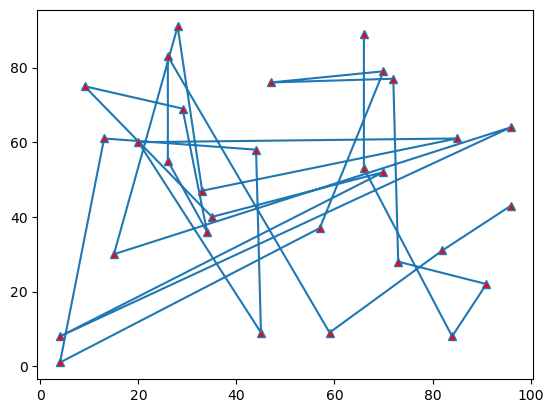

In [20]:
plt.plot(x, y, marker = "^", markerfacecolor = "r")